## 1) Import modules

In [2]:
using SudokuPlantDesign
using BenchmarkTools
using BlockArrays
using DataFrames
using Random
using XLSX
using PyPlot
using ColorTypes
using PyCall
@pyimport matplotlib.colors as matcolors

┌ Info: Precompiling SudokuPlantDesign [89b4fab0-2f28-41bc-964f-884dedc0e1f4]
└ @ Base loading.jl:1260
┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:413
└ @ PyCall C:\Users\Jan\.julia\packages\PyCall\7a7w0\src\PyCall.jl:413


## 2) Define sudoku trial layout and generate an initial random check distribution

Generate a new configuration `conf` which is divided into 2 horizontal and 5 vertical blocks of dimensions `10` x `2` respectively. In total, there are `4` different checks in the configuration.

As an optional argument, the boundary conditions (present in the optimization algorithm later on) can be passed as an argument `bc`. Values are either `:periodic` or `open`. 

In [3]:
conf = get_configuration(
    [10,10],  [2,2,2,2,2],    4
    ;
    bc = :open
);

Show the configuration `conf` utilizing a zoom factor of `0.2`. Initially, all plots are assumed to be genotypes.

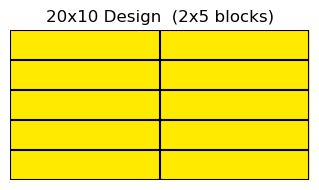

In [4]:
show_configuration(conf, zoom=0.2)

You can designate empty plots which will be ignored in the sudoku optimization (missing plots, etc). In this example, leave the plot `[1,3]` and `[1,4]` empty. Configuration is plotted again to show the update.

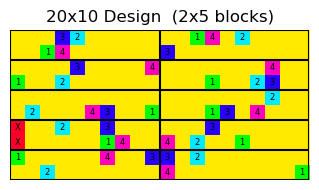

In [9]:
empty_plots!(conf, 1:1,3:4)
show_configuration(conf, zoom=0.2)

Checks can be initialized randomly with one check per check type per block.

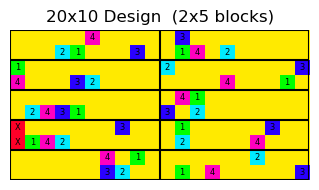

In [10]:
initialize_checks_per_block!(conf)
show_configuration(conf, zoom=0.2)

For saving, you can utilize the `PyPlot` command `savefig` which saves the current figure as an image file.

In [11]:
savefig("output/initial_random_check_distribution.png")

## 3) Define sudoku functions

### Define inverse temperature function

...

In [ ]:
beta(t) = 1*exp(-7*t) * (1 + 0.2*cos(t*30*pi))

In [ ]:
plot(0:0.001:1, beta.(0:0.001:1))
xlabel("rel. update"); ylabel("T")

### Select individual cost function for optimization
You can define and give certain weights to the individual cost functions:
- `K_num_checks_equal_per_type` : Optimizes to get an equal amount of checks per type in the design.
- `K_checks_per_type_per_block` : Optimizes to get an equal amount of checks per type per each block, give it a weight of `20`.
- `K_neighbors_different_check_functional` : Optimizes the repulsive potential of different neighboring checks (e.g. check 1 and check 3)
- `K_neighbors_same_check_functional` : Optimizes the repulsive potential of same neighboring checks (e.g. check 1 and check 1)

In [ ]:
function K_indiv(conf :: C) :: Float64 where {C <: CheckConfiguration}
    return  K_num_checks_equal_per_type(conf) +
            K_checks_per_type_per_block(conf, 1)*20+
            K_neighbors_different_check_functional(conf, d->0.5/(d^3)) +
            K_neighbors_same_check_functional(conf, d->1/(d^3))
end

### Define update moves.
Select which update moves you want to occur. `UpdateNewCheckLabel` puts new checks into the design, `UpdateSwapCheckCheck` swaps checks with other checks, and `UpdateSwapCheckGenotype` swaps checks with genotypes. Run `100000` updates.

In [ ]:
kosten = optimize_design!(
    C,
    [UpdateNewCheckLabel(),UpdateSwapCheckCheck(),UpdateSwapCheckGenotype()],
    K_indiv,
    100000,
    beta
)

## 4) Run sudoku optimization

In [ ]:
#initialize_genotypes!(C, numberofgenotypes)
@showprogress "Optimizing Design ... " for i in 1:length(kosten)
    mc_update!(C, beta(i/length(kosten))*0.5, updates, K_indiv)
    kosten[i] = K_indiv(C)
end

In [ ]:
kosten .-= minimum(kosten)
kosten .+= 1

#print things
println("Kosten: ",K_indiv(C)+kosten[1], " -> ", K_indiv(C)+kosten[end])
println("perc_checks: ",C.num_checks_total / (C.num_plots_total - C.num_checks_total))
println("genotypes: ",C.num_plots_total - C.num_checks_total)
println("checks:    ",C.num_checks_total, "  (", round(100*C.num_checks_total / C.num_plots_total, digits=2), "%)")
for i in 1:C.N
    println("check ($(i)): ",C.num_checks[i], "  (", round(100*C.num_checks[i] / C.num_checks_total, digits=2), "%)")    
end

show_configuration(C,cmap=cmap_sudoku,zoom=0.2)


figure()
plot(kosten)
yscale("log")


#save without check labels
show_configuration(C,check_labels=false,cmap=cmap_sudoku)
#savefig("final_sudoku_design_"*trialname*".png")
savefig("final_sudoku_design_"*trialname*".pdf")

## 6) Plot with Plant_Codes and write data to xlsx

## 5) Save field plan and design data

In [ ]:
templatename="Sample_data_Sudoku-augmented.xlsx"

#read in check data
checkdata = DataFrame(XLSX.readtable(templatename, "checks")...)
checknames=names(checkdata)
for i in 1:length(checknames)
    checkdata[!,Symbol(checknames[i])]=string.(collect(checkdata[!,Symbol(checknames[i])]))
end
if nrow(checkdata)!= numberofchecktypes
    println("Number of checks in csv not matching pre-defined checks!")
end


#replace missing with NA
for col in eachcol(checkdata)
    replace!(col,missing => "NA")
end


#depending on reading in additionally genotype file
if  designtype=="checks"
    print("Only checks were successfully read in, as specified")
    
elseif designtype=="all"
    #read in genotype data
    genotypedata = DataFrame(XLSX.readtable(templatename, "entries")...)
    genonames=names(genotypedata)
    for i in 1:length(checknames)
        genotypedata[!,Symbol(genonames[i])]=string.(collect(genotypedata[!,Symbol(genonames[i])]))
    end
    #replace missing with NA
    for col in eachcol(genotypedata)
        replace!(col,missing => "NA")
    end
    
    #catch if not matching number of genotypes
    if nrow(genotypedata)!= numberofgenotypes
        println("Number of genotypes in xlsx datafile not matching pre-defined number of genotypes!")
    end
    
    
    #shuffle genotypedata?
    if entries_randomized=="yes"
        genotypedata = genotypedata[shuffle(1:nrow(genotypedata)), :]
        genotypedata[!,:genotype]=string.(collect(genotypedata[!,:genotype]))
        print("Entries are randomized ")
        #print(genotypedata)

    elseif entries_randomized=="no"
        print("Entries are not randomized")
        #print(genotypedata)

    else
        print("Specify if genotypes are randomized or sorted with entries_randomized yes/no!")

    print("genotypes and checks are successfully read in")
    end
    
else
    print("Please specify designtype (checks/all)!")
        
end

#get the Plant label
#POS = get_POS_block_x(C,posempty=true) #if over 2 big blocks in splitted by x
POS = get_POS_coordinatewise(C,"x","left","lower","snake") #with robot

if designtype=="checks"
    L = get_Plant_Code_Label_allinfo_checksonly(C,POS,checkdata)
else
    L = get_Plant_Code_Label_allinfo(C,POS,genotypedata,checkdata)
end   

show_pos_and_labels_allinfo(C, POS, L, zoom=0.9,fontsize=7,alpha=0.5,cmap=cmap_sudoku)
savefig("final_sudoku_design_labels_"*trialname*".pdf")

In [ ]:
#write file to xlsx
write_to_xlsx_allinfo(C.configuration,trialname,POS,L)


#load_configuration(C, "configuration_"*trialname*".txt")
save_configuration(C, "configuration_"*trialname*".txt")
